In [1]:
import tensorflow as tf
import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Flatten,Dropout,concatenate,UpSampling2D
from keras.layers import Input, Reshape, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Lambda,Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D
from keras import backend as K
from keras.models import Model
import keras
from keras.preprocessing import image
from keras.layers.core import RepeatVector, Permute
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import numpy as np
import math
from livelossplot import PlotLossesKeras
from os import walk
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.initializers import glorot_uniform
from skimage.transform import resize
from keras.applications import VGG19
from skimage.io import imsave
import os
from flow_from_directory_regress import ImageDataGeneratorReg
from keras.utils import multi_gpu_model
import discriminator as _discriminator
from discriminator import Discriminator
from IPython.display import clear_output
from skimage import io, color
from skimage.transform import resize

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# global varibles
trainset_path = "datasets/trainset"
devset_path = "datasets/devset"
testset_path = "datasets/testset"
batch_size = 16
# epochs
iteration = 100

target_size = (256, 256)

In [3]:
#Create embedding\
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()
def create_inception_embedding(grayscaled_rgb):
    #Load weights    
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = np.expand_dims(i, axis=-1)
        i = np.repeat(i, 3, axis=-1)
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized*255)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

In [4]:
# Model
def conv_stack(data, filters, s):
        output = Conv2D(filters, (3, 3), strides=s, activation='relu', padding='same')(data)
        #output = BatchNormalization()(output)
        return output

def residual_block(layer_input, filters):
    """Residual block described in paper"""
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
    d = Activation('relu')(d)
    d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
    d = Add()([d, layer_input])
    return d
    

def get_model():
    embed_input = Input(shape=(1000,))
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = conv_stack(encoder_input, 64, 2)
    encoder_output = conv_stack(encoder_output, 64, 1)
    encoder_output = conv_stack(encoder_output, 128, 2)
    encoder_output = conv_stack(encoder_output, 128, 1)
    encoder_output = conv_stack(encoder_output, 256, 2)
    encoder_output = conv_stack(encoder_output, 256, 1)
    encoder_output = conv_stack(encoder_output, 256, 1)
    encoder_output = conv_stack(encoder_output, 256, 1)
    
    x = residual_block(encoder_output, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    encoder_output = Add()([x, encoder_output])
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input)
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([fusion_output, encoder_output], axis=3)
    fusion_output = Conv2D(256, (1, 1), activation='relu')(fusion_output)

    #Decoder
    decoder_output = conv_stack(fusion_output, 128, 1)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = conv_stack(decoder_output, 64, 1)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = conv_stack(decoder_output, 32, 1)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = conv_stack(decoder_output, 16, 1)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
    return model

In [5]:
# initial model, Attention: weights are gone...
model = get_model()
model.summary()
#adam = keras.optimizers.Adam(lr=0.0001)
#model.compile(optimizer=adam, loss='mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 64, 64, 128)  73856       conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207

In [6]:
# Functions for Data 
def get_file_count(path):
    f = []
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
    return len(f)
 
def process_train_batch_X(batch, filenames, index_array):
    grayscaled_rgb = rgb2gray(batch)
    embed = create_inception_embedding(grayscaled_rgb)
    lab_batch = rgb2lab(batch)
    X_batch = lab_batch[:,:,:,0]
    X_batch = X_batch.reshape(X_batch.shape+(1,))
    return [X_batch, embed]

def process_batch_Y(batch, filenames, index_array):
    lab_batch = rgb2lab(batch)
    Y_batch = lab_batch[:,:,:,1:] / 128
    return Y_batch

def get_generator(path):
    if path == trainset_path:
        # aug
        datagen = ImageDataGeneratorReg(shear_range=0,
                                        zoom_range=0,
                                        rotation_range=40,
                                        horizontal_flip=True,
                                        preprocessing_function=preprocess_input)
    else:
        #non aug
        datagen = ImageDataGeneratorReg(preprocessing_function=preprocess_input)
    iterator = datagen.flow_from_directory(
        path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='input',
        # testset doesn't need shuffle, filnames will mismatch after shuffle!!!
        shuffle=(path == trainset_path))
    return iterator

In [7]:
# Init Data
train_generator = get_generator(trainset_path)
train_generator.register_batch_process(process_train_batch_X, process_batch_Y)
nb_train_samples = len(train_generator.filenames)
filenames = train_generator.filenames

dev_generator = get_generator(devset_path)
dev_generator.register_batch_process(process_train_batch_X, process_batch_Y)
nb_dev_samples = len(dev_generator.filenames)

Found 699 images belonging to 1 classes.
Found 49 images belonging to 1 classes.


In [ ]:
# Train.. non GAN
%autosave 100
print(model.metrics_names)
checkpointer = ModelCheckpoint(filepath='best_weights_new_bro.hdf5',
                               monitor='mse',
                               mode='min',
                               save_weights_only=True,
                               verbose=1, save_best_only=True)
model.fit_generator(train_generator, 
                    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
                    epochs=iteration,
                    
         callbacks = [PlotLossesKeras(), checkpointer])

In [ ]:
model.save_weights("./best_weights_new_bro.h5")

In [8]:
# GAN Definition
import random
import time
import copy
D = Discriminator()
discriminator = D.get_model()
patch = int(target_size[0] / 2**2)
disc_patch = (patch, patch, 1)
embed_input = Input(shape=(1000,))
encoder_input = Input(shape=(256, 256, 1,))
clr_img_ab = model([encoder_input, embed_input])
clr_img = concatenate([encoder_input, clr_img_ab], axis=-1)
valid = discriminator(clr_img)
gan = Model([encoder_input, embed_input], [clr_img_ab, valid])
gan = multi_gpu_model(gan, gpus=3)
d_acc_arr = []
g_loss_arr = []
g_d_loss_arr = []

In [10]:
# settings
epochs = 150
mini_batches = 44 * epochs
def plot_loss(d_acc_arr, g_loss_arr, g_d_loss_arr):
    global epochs
    fig = plt.figure(figsize=(12,4))
    x = range(len(d_acc_arr))
        
    fig = plt.subplot(1, 2, 1)
    fig.set_xlim(1, epochs)
    plt.plot(x, d_acc_arr, label="discriminator accuracy")
    plt.title("Discriminator Accuracy")
    
    fig = plt.subplot(1, 2, 2)
    fig.set_xlim(1, epochs)
    plt.plot(x, g_loss_arr, label="generator content loss")
    plt.plot(x, g_d_loss_arr, label="adversarial loss")
    plt.title("Losses")
    
    plt.legend()
    plt.show()

In [11]:
# Compile GAN

discriminator.trainable = True
optimizer = RMSprop(0.00005)
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False
gan.compile(loss='mse', optimizer=optimizer, loss_weights = [1, 0.1])

In [12]:
d_acc_sum = 0
g_loss_sum = 0
g_d_loss_sum = 0

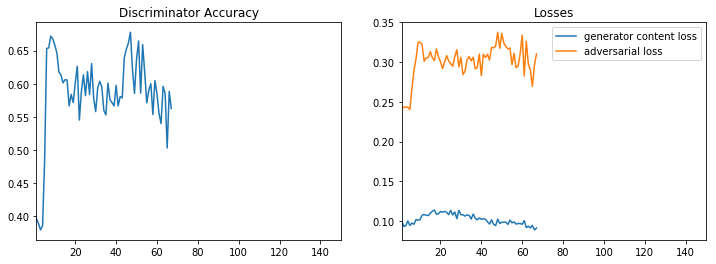

batch: 2993 d_loss: [0.17409398 0.9523773 ] g_loss [0.13440073 0.09553316 0.3886757 ] time: 3.78
batch: 2994 d_loss: [0.31523877 0.45739746] g_loss [0.13181327 0.10245749 0.29355785] time: 3.44
batch: 2995 d_loss: [0.21503969 0.72063446] g_loss [0.13869348 0.09875159 0.39941883] time: 3.93
batch: 2996 d_loss: [0.25275433 0.49925232] g_loss [0.10645198 0.08465832 0.21793656] time: 3.53
batch: 2997 d_loss: [0.20661531 0.531868  ] g_loss [0.11729515 0.0902821  0.27013046] time: 3.59
batch: 2998 d_loss: [0.3180331 0.1153717] g_loss [0.09593881 0.08142572 0.14513092] time: 3.99
batch: 2999 d_loss: [0.15009612 0.96982574] g_loss [0.13288236 0.0935311  0.39351255] time: 4.28
batch: 3000 d_loss: [0.22072467 0.7609024 ] g_loss [0.12351672 0.09192672 0.31590006] time: 3.61
batch: 3001 d_loss: [0.18392935 0.8007126 ] g_loss [0.12556657 0.11117348 0.14393091] time: 3.73
batch: 3002 d_loss: [0.22436273 0.5773392 ] g_loss [0.12960817 0.10052462 0.2908355 ] time: 3.63
batch: 3003 d_loss: [0.28393707 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
# Train GAN
%autosave 100

print(discriminator.metrics_names, gan.metrics_names)
start_mini_batch = 1
dNetTrainable = True
for i in range(start_mini_batch, mini_batches+1):
    time_tick = time.time()
    # get data
    (X, embed), Y = train_generator.next()
    b_s = X.shape[0]
    
    valid = np.ones((b_s,) + disc_patch)
    fake = np.zeros((b_s,) + disc_patch)
    
    # ---------------
    # get a predict lab image
    # ---------------
    clr_img_ab = model.predict([X, embed])
    clr_img = np.zeros((b_s,)+target_size+(3,))
    clr_img[:,:,:,0] = X[:,:,:,0]
    clr_img[:,:,:,1:] = clr_img_ab
    
    # ---------------
    # train discriminators
    # ---------------
    if dNetTrainable:
        d_loss_fake = discriminator.train_on_batch(clr_img, fake)
        clr_img[:,:,:,1:] = Y
        d_loss_real = discriminator.train_on_batch(clr_img, valid)
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        d_acc_sum += d_loss[1]
    else:
        d_loss = np.array([0,0])
        d_acc_sum += 0
    # ---------------
    # train generator
    # ---------------
    (X, embed), Y = train_generator.next()
    b_s = X.shape[0]
    valid = np.ones((b_s,) + disc_patch)
    g_loss = gan.train_on_batch([X, embed], [Y, valid])
    g_loss = np.array(g_loss)
    
    #(X, embed), Y = train_generator.next()
    #b_s = X.shape[0]
    #valid = np.ones((b_s,) + disc_patch)
    #g_loss += gan.train_on_batch([X, embed], [valid])
    #g_loss = g_loss/2
    
    g_d_loss_sum += g_loss[2]
    g_loss_sum += g_loss[1]
    esclapse_time = time.time() - time_tick
    print("batch:", i, "d_loss:", d_loss, "g_loss", g_loss, "time:", round(esclapse_time,2))
    
    if i % 44 == 0:
        d_acc_arr.append(d_acc_sum/44)
        if dNetTrainable:
            if d_acc_arr[-1] > 0.7:
                dNetTrainable = False
        else:
            acc = discriminator.evaluate(clr_img, fake)[1]
            if acc<0.6:
                dNetTrainable = True
            print("DNet Acc:", acc)
        if d_acc_arr[-1] == 0:
            d_acc_arr[-1] = d_acc_arr[-2]
            
        g_loss_arr.append(g_loss_sum/44)
        g_d_loss_arr.append(g_d_loss_sum/44)
        d_acc_sum = g_loss_sum = g_d_loss_sum = 0
        clear_output(wait=True)
        plot_loss(d_acc_arr, g_loss_arr, g_d_loss_arr)
        
        file = "./datasets/devset/1/00000010.jpg"
        img0 = resize(io.imread(file), target_size)
        tmp = img0.reshape((1,)+img0.shape)
        X, embed = process_train_batch_X(tmp, '', None)
        clr_img_ab = model.predict([X, embed]) *128
        img_lab = rgb2lab(img0)
        img_lab[:,:,1:] = clr_img_ab[0]
        img = lab2rgb(img_lab)
        io.imsave("./realtime_test/epoch_%04d.png"%(i/44), img)
        
    if i % 88 == 0:
        model.save_weights('./models/best_model_epoch_%04d.h5' % (i/44))

In [ ]:
f = open('curve2.py', 'w')
f.write("d_acc_arr="+str(d_acc_arr) + "\n")
f.write("g_loss_arr="+str(g_loss_arr) + "\n")
f.write("g_d_loss_arr="+str(g_d_loss_arr) + "\n")

In [19]:
#model.save_weights('best_weights_gan.hdf5')
model.load_weights('best_weights_new_bro.h5')

In [ ]:
# Dev evaluate only
#model.evaluate_generator(dev_generator, steps=math.ceil(nb_dev_samples / batch_size))

In [23]:
color_dict = {}
color_dict_max = {}
color_dict_max_ab = {}
def same_grey_same_colorize(AB, L):
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            l = L[i][j]
            ab = list(map(lambda x:int(x), AB[i][j] + 128))
            if l not in color_dict:
                color_dict[l] = [[0]*256]*256
                color_dict_max[l] = 0
            color_dict[l][ab[0]][ab[1]] += 1
            if color_dict[l][ab[0]][ab[1]] > color_dict_max[l]:
                color_dict_max[l] = color_dict[l][ab[0]][ab[1]]
                color_dict_max_ab[l] = AB[i][j]
                
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            l = L[i][j]
            AB[i][j] = color_dict_max_ab[l]
    return AB

In [ ]:
file = "./datasets/devset/1/00000010.jpg"
img0 = resize(io.imread(file), target_size)
tmp = img0.reshape((1,)+img0.shape)
X, embed = process_train_batch_X(tmp, '', None)
clr_img_ab = model.predict([X, embed]) *128
img_lab = rgb2lab(img0)
img_lab[:,:,1:] = clr_img_ab[0]
img = lab2rgb(img_lab)
io.imsave("./realtime_test/test.png", img)

Found 49 images belonging to 1 classes.


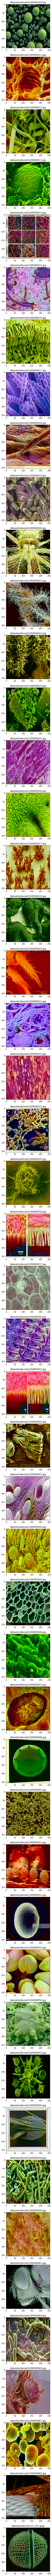

In [24]:
# Test

path = devset_path
test_generator = get_generator(path)
test_generator.register_batch_process(process_train_batch_X)
filenames = test_generator.filenames
nb_test_samples = len(test_generator.filenames)

#preds = preds[:3]
fig = plt.figure(figsize=(256, 256))
for i in range(0,len(filenames)):
    filename = path+'/'+filenames[i]    
    img0 = resize(io.imread(filename), target_size)
    tmp = img0.reshape((1,)+img0.shape)
    X, embed = process_train_batch_X(tmp, '', None)
    clr_img_ab = model.predict([X, embed]) *128
    img_lab = rgb2lab(img0)
    L = X.reshape((X.shape[1],X.shape[2]))
    img_lab[:,:,1:] = same_grey_same_colorize(clr_img_ab[0], L)
    img = lab2rgb(img_lab)
    a=fig.add_subplot(len(filenames), 1,i+1)
    imgplot= plt.imshow(img)
    a.set_title(filename)
    io.imsave("results/result_%02d.png"%i, img)